# AlphaGo Demo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import product
import torch as torch
import torch.nn as nn
import torch.optim as optim
import copy
import torch.nn.functional as F

## 定义棋盘
作用：记录棋局状态，记录棋局下子顺序，判断局面是否输赢，执行下子过程，可视化等

In [2]:
class Board():
    def __init__(self, length, width, start_player=1, state=None):
        self._length = length
        self._width = width
        self._state = (state if isinstance(state, np.ndarray) else np.zeros(shape=(length, width))) # 棋局状态
        self._step = []  # 棋局走子历史记录
        self._start_player = start_player # 下棋角色
        
    def is_full(self):
        return 0 not in self._state
    
    def availables(self):
        position = np.where(self._state.T==0)
        avalable_action = [(x, y) for x, y in zip(position[1], position[0])]
        return avalable_action
    
    def is_end(self, show_result=True):  # 暴力检查打竖，打横，打竖（切成多个5*5的矩阵计算）
        
        # 判断和局
        if 0 not in self._state:
#             self.show()
            return 0
            
    
        # 判断谁胜
        for w in range(self._width-4):
            for l in range(self._length-4):
                sub_state = self._state[w: w+5, l: l+5]   
                row_check = sub_state.sum(axis=1) # 横
                col_check = sub_state.sum(axis=0) # 竖
                down_check = sub_state[np.identity(5)==1].sum() # 斜下      
                up_check = sub_state[np.fliplr(np.identity(5))==1].sum() # 斜上
                
                if (np.abs(row_check) == 5).any():
                    (temp_r, temp_l) = self._step[-1]
                    if show_result:
                        self.show(show_line=([l, l+4], [temp_r, temp_r])) 
                    return row_check[np.abs(row_check) == 5][0] // 5
                
                if (np.abs(col_check) == 5).any():
                    (temp_r, temp_l) = self._step[-1]
                    if show_result:
                        self.show(show_line=([temp_l, temp_l], [w, w+4]))
                    return col_check[np.abs(col_check) == 5][0] // 5
            
                if abs(down_check) // 5 == 1:
                    if show_result:
                        self.show(show_line=([l, l+4], [w, w+4]))
                    return down_check // 5
                
                if abs(up_check) // 5 == 1:
                    if show_result:
                        self.show(show_line=([l, l+4], [w+4, w]))
                    return up_check // 5
        return 'not end'

    def add(self, pos, show=True):
        if self.is_full():
            print('不能再下了')
            return None
        
        if self._state[pos[0],pos[1]] != 0:
            print('已经有棋子了')
            return None
        
        self._step.append(pos)
        self._state[pos[0],pos[1]] = self._start_player
        self._start_player = self._start_player * -1 # 下次下子是另一个选手
        
        if show:
            self.show(show_step=pos)
    
    
    def show(self, show_step=False, show_line=False, show_pro=False, pro_from='UNKNOW', show_train_info=False,):
        plt.figure(figsize=(9, 6.5))
        
        # 显示下子点
        for i, color in zip([1, -1], ['white', 'grey']):
            temp = np.where(self._state.T==i)
            plt.scatter(temp[0], temp[1], s=700, edgecolors='grey', c=color, linewidths=1)
            plt.scatter(-3, -3, s=120, c=color, label='Player {}'.format(i), edgecolors='grey') # 画legend用
            
        # 显示下子步骤
        if show_step:
            
            # 该步红点提示
            plt.scatter(show_step[1], show_step[0], s=300, c='red', alpha=0.8)
            plt.scatter(-3, -3, s=120, c='red', label='step', alpha=0.8) # 画legend用
            
            # 侧面信息
            plt.text(10.6, 3.8, 'STEP:{}'.format(100-len(self.availables())), fontsize=20)
            plt.text(10.6, 2.8, 'GAMEING', fontsize=22)
            plt.text(10.6, 4.8, 'POS:({},{})'.format(show_step[0], show_step[1]), fontsize=20)
            
            # 下子文字顺序
            for idx, i in enumerate(self._step):
                plt.text(i[1], i[0], idx+1, fontsize=14, color='black', ha='center', va='center')
        
        # 显示胜利情况
        if show_line:
            plt.plot(show_line[0], show_line[1], color='red', linewidth=4, label='win', alpha=0.8)
            plt.text(10.6, 3.8, 'STEP:{}'.format(100-len(self.availables())), fontsize=20)
            plt.text(10.6, 2.8, 'GAME OVER', fontsize=22)
            plt.text(10.6, 4.8, 'WINNER:{}'.format(self._start_player*-1), fontsize=20)
            
        # 显示下子概率
        if show_pro:
            y_data = [x[0] for x in show_pro.keys()]
            x_data = [x[1] for x in show_pro.keys()]
            plt.scatter(x_data, y_data, s=700, c='green')
            for pro, x, y in zip(show_pro.values(), x_data, y_data):
                plt.text(x, y, pro, fontsize=11, color='white', ha='center', va='center')
            plt.scatter(-3, -3, s=120, c='green', label='Value Function', alpha=0.8) # 画legend用
            plt.text(10.6, 3.8, 'PREDICT FROM', fontsize=20)
            plt.text(10.6, 4.9, pro_from, fontsize=35)
            
             
        # 显示训练情况
        if show_train_info:
            plt.text(10.6, 6.8, 'TRAIN INFO', fontsize=22)
            plt.text(10.6, 7.8, 'EPOCH:{}'.format(show_train_info[0]), fontsize=20)
            plt.text(10.6, 8.8, 'LOSS:{}'.format(show_train_info[1]), fontsize=20)
            
        
        # 画方框
        plt.plot([-1, -1, 10, 10, -1], [-1, 10, 10, -1, -1], color='black', alpha=0.5)
        plt.plot([10, 15], [10, 10], color='black', alpha=0.8)
        
        # 设置坐标轴
        ax=plt.gca() 
        ax.spines['bottom'].set_position(('data',-1))
        ax.spines['left'].set_position(('data',-1))
        ax.xaxis.set_ticks_position('top')
        plt.xlim(-1, self._width)
        plt.ylim(self._length, -1)
        plt.xticks([ x for x in range(self._width+6)])
        plt.yticks([ x for x in range(self._length)])
        
        # 画图
        plt.legend(loc='upper right')
        plt.grid(alpha=0.3)
        plt.show()
        
    # 训练显示用    
    def show_for_train(self, mcts_bar_data, mcts_action_pro_dict, mcts_v, nn_action_pro_dict, train_info):
        plt.figure(figsize=(16,8))  # 设置图形框大小
        
        # mcts树展开情况
        ax1 = plt.subplot2grid(shape=(6, 6), loc=(0,0), rowspan=2, colspan=6,)
        ax1.set_title('MTCS TREE ROOT NODE EXOAND')
        ax1.bar([x for x in range(len(mcts_bar_data))], mcts_bar_data)
        ax1.set(ylim=[0, max(mcts_bar_data)+10]) 
        ax1.get_xaxis().set_visible(False)
        
        
        # mcts预测
        ax2 = plt.subplot2grid(shape=(6, 6), loc=(2,0), rowspan=4, colspan=3)
        y_data = [x[0] for x in mcts_action_pro_dict.keys()]
        x_data = [x[1] for x in mcts_action_pro_dict.keys()]
        ax2.scatter(x_data, y_data, s=500, c='green', alpha=0.5)
        for pro, x, y in zip(mcts_action_pro_dict.values(), x_data, y_data):
            plt.text(x, y, '{:.2f}'.format(pro), fontsize=9, color='black', ha='center', va='center')
        plt.scatter(-3, -3, s=120, c='green', label='Action Value', alpha=0.8) # 画legend用
        plt.text(10.6, 2.9, 'MCTS', fontsize=30)
        plt.text(10.6, 3.9, 'TOP 5', fontsize=15)
        plt.text(10.6, 5.4, 'Children:{}'.format(len(mcts_bar_data)), fontsize=15)
        plt.text(10.6, 8.9, 'S(t):{:.2f}'.format(mcts_v), fontsize=20)


        # train图
        ax3 = plt.subplot2grid(shape=(6, 6), loc=(2,3), rowspan=4, colspan=3)
        y_data = [x[0] for x in nn_action_pro_dict.keys()]
        x_data = [x[1] for x in nn_action_pro_dict.keys()]
        ax3.scatter(x_data, y_data, s=500, c='blue', alpha=0.5)
        for pro, x, y in zip(nn_action_pro_dict.values(), x_data, y_data):
            plt.text(x, y, '{:.2f}'.format(pro), fontsize=9, color='black', ha='center', va='center')
        plt.scatter(-3, -3, s=120, c='blue', label='NN Predict Pro', alpha=0.8) # 画legend用
        plt.text(10.6, 2.9, 'RESNET', fontsize=30)
        plt.text(10.6, 3.9, 'TRAIN INFO', fontsize=15)
        plt.text(10.6, 5.9, 'EPOCH:{}'.format(train_info[0]), fontsize=20)
        plt.text(10.6, 6.9, 'LOSS:{}'.format(train_info[1]), fontsize=20)
        plt.text(10.6, 8.9, 'S(t):{:.2f}'.format(train_info[2]), fontsize=20)

        
        # 共有部分
        for ax in [ax2, ax3]:
            
            # 下子情况
            for i, color in zip([1, -1], ['white', 'grey']):
                temp = np.where(self._state.T==i)
                ax.scatter(temp[0], temp[1], s=500, edgecolors='grey', c=color, linewidths=1)
                ax.scatter(-3, -3, s=120, c=color, label='Player {}'.format(i), edgecolors='grey') # 画legend用
            
            # 其他
            ax.spines['bottom'].set_position(('data',-1))
            ax.spines['left'].set_position(('data',-1))
            ax.xaxis.set_ticks_position('top')
            ax.set(xlim=[-1, self._width], ylim=[self._length, -1])
            ax.set_xticks([ x for x in range(self._width+6)])
            ax.set_yticks([ x for x in range(self._length)])
            ax.grid(alpha=0.3)
            ax.plot([-1, -1, 10, 10, -1], [-1, 10, 10, -1, -1], color='black', alpha=0.5)
            ax.plot([10, 15], [10, 10], color='black', alpha=0.8)
            ax.legend(loc='upper right')
        
        
        plt.show()

## 可视化测试

初始化棋局（中间状态）


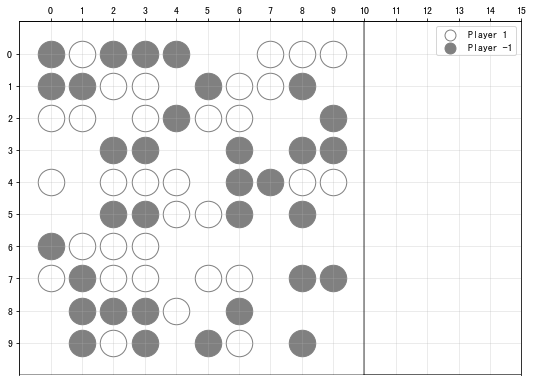

下一步棋


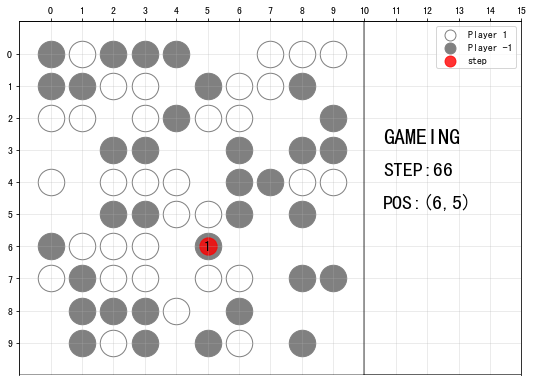

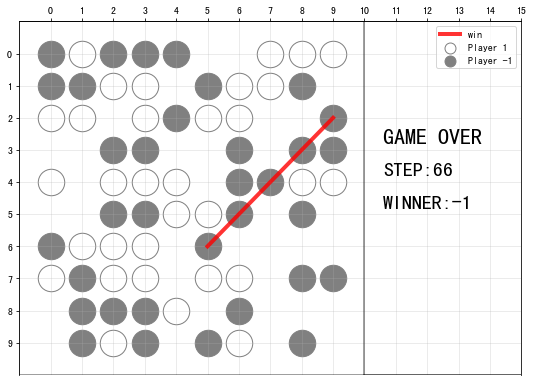

结束返回结果 -1.0


In [3]:
# test
temp = np.array([
        [ -1, 1.,  -1, -1.,  -1,  0.,  0.,  1.,  1.,  1.],
       [-1., -1.,  1.,  1.,  0., -1.,  1.,  1., -1.,  0.],
       [ 1.,  1.,  0.,  1., -1.,  1.,  1.,  0.,  0.,  -1],
       [ 0.,  0.,  -1, -1.,  0., 0., -1.,  0., -1., -1.],
       [ 1.,  0.,  1.,  1, 1.,  0., -1., -1.,  1.,  1.],
       [ 0., 0, -1., -1.,  1.,  1., -1.,  0., -1.,  0.],
       [-1., 1, 1.,  1.,  0,  0,  0.,  0.,  0.,  0.],
       [ 1., -1.,  1.,  1., 0,  1.,  1.,  0., -1., -1.],
       [ 0., -1., -1., -1.,  1.,  0., -1.,  0.,  0.,  0.],
       [ 0., -1.,  1., -1.,  0., -1.,  1.,  0., -1.,  0.]])

print('初始化棋局（中间状态）')
b = Board(10, 10, -1, temp)
b.show()
print('下一步棋')
b.add((6,5), show=True)
# print('下一步棋')
# b.add((6,7))
# print('下一步棋')
# b.add((3,2))
# print('胜负判断')
print('结束返回结果', b.is_end(show_result=True))

# 定义Restnet网络
未加rule层

In [4]:
class ResNet(nn.Module):
    def __init__(self, board_length, board_width):
        super(ResNet, self).__init__()
        self.board_length = board_length
        self.board_width = board_width
    
        # 通用特征提取层
        self.common = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU()
        )
    
        # 价值网络 v
        self.value_fc_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=2, kernel_size=1),
            nn.ReLU()
        )
        self.value_fc_2 = nn.Sequential(
            nn.Linear(2*self.board_length*self.board_width, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Tanh()
        )
    
        # 策略网络 p
        self.policy_fc_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=4, kernel_size=1),
            nn.ReLU(),
        )
        self.policy_fc_2 = nn.Sequential(
            nn.Linear(4*self.board_length*self.board_width, self.board_length*self.board_width),
            nn.ReLU()
        )
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, state):
        
        # 格式转换
        if not isinstance(state, torch.Tensor):
            x = torch.Tensor(state).unsqueeze(0).unsqueeze(0)
        
        # 特征提取层
        x = self.common(x)
        
        # 价值 value
        value = self.value_fc_1(x)
        value = value.view(-1, 2*self.board_length*self.board_width)
        value = self.value_fc_2(value)
        
        # 策略 policy
        policy = self.policy_fc_1(x)
        policy = policy.view(-1, 4*self.board_length*self.board_width)
        policy = self.policy_fc_2(policy)
        policy = self.softmax(policy)

        return value, policy

In [5]:
# test
model = ResNet(10, 10)
value, policy = model(temp)
torch.save(model, './temp_model.pt')
policy[0][12].item()

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.009865360334515572

In [6]:
policy

tensor([[0.0099, 0.0099, 0.0102, 0.0099, 0.0099, 0.0104, 0.0099, 0.0099, 0.0099,
         0.0107, 0.0099, 0.0105, 0.0099, 0.0099, 0.0099, 0.0100, 0.0099, 0.0099,
         0.0099, 0.0105, 0.0099, 0.0099, 0.0099, 0.0104, 0.0099, 0.0099, 0.0099,
         0.0099, 0.0099, 0.0099, 0.0099, 0.0102, 0.0099, 0.0103, 0.0100, 0.0103,
         0.0099, 0.0099, 0.0105, 0.0102, 0.0099, 0.0100, 0.0099, 0.0099, 0.0099,
         0.0102, 0.0099, 0.0099, 0.0104, 0.0099, 0.0099, 0.0099, 0.0101, 0.0099,
         0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0101, 0.0099, 0.0102,
         0.0099, 0.0101, 0.0103, 0.0099, 0.0099, 0.0099, 0.0101, 0.0099, 0.0099,
         0.0104, 0.0102, 0.0102, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099,
         0.0101, 0.0101, 0.0099, 0.0099, 0.0099, 0.0103, 0.0101, 0.0105, 0.0099,
         0.0099, 0.0100, 0.0099, 0.0099, 0.0099, 0.0104, 0.0103, 0.0099, 0.0099,
         0.0103]], grad_fn=<SoftmaxBackward>)

In [7]:
value

tensor([[-0.1162]], grad_fn=<TanhBackward>)

# 定义 Player
1. self-play对奕阶段：直接使用前一段时间生成的RestNet网络进行自我对奕
2. 人机对奕阶段：使用训练好最好的网络进行对奕

In [8]:
class Player():
    def __init__(self, pattern='train', model_path='./temp_model.pt'):
        self.model_path = model_path
        self.brain = self.get_brain(pattern)
        self.play = self.get_play_model(pattern)
        self.idx_to_position =  {x: y for x, y in enumerate(product([x for x in range(10)], repeat=2))}
    
    # 根据模式选择加载哪个训练好的模型
    def get_brain(self, pattern):
        if pattern == 'train':
            return torch.load(self.model_path)
        elif pattern == 'AI':
            return torch.load(self.model_path)
        else:
            pass
    
    # 选择模式
    def get_play_model(self, pattern):
        if pattern == 'random':
            return self.play_random
        if pattern == 'human':
            return self.play_human
        else:
            return self.play_ai
    
    # 真实人模式
    def play_human(self, board, action, show=True):
        board.add(action, show)
        return board
    
    # 随机模式
    def play_random(self, board, action='auto', show=True):
        action = random.choice(board.availables())
        board.add(action, show)
        return board
    
    # 智能模式
    def play_ai(self, board, action='auto', show=True):
        
        # ResNet进行计算得到value和policy
        value, policy = self.brain(board._state)
        
        # 贪心策略选择，每次选择最好的
        for i in range(board._length * board._width):
            action = self.idx_to_position[policy.topk(i+1)[1][0, -1].item()]
            if action in board.availables():
                board.add(action, show)
                return board
            else:
                continue

In [9]:
# 自动对奕
def self_play(player1, player2, play_round=100, show=False):
    record = []
    
    for i in range(play_round):
        game = Board(10, 10)
        next_game = False
        
        while next_game == False:
            for player in [player1, player2]:
                game = player.play(game, show=show) 
                result = game.is_end(show_result=show)
                if result != 'not end':
                    next_game = True
                    record.append(result)
                    break

    return record                
    

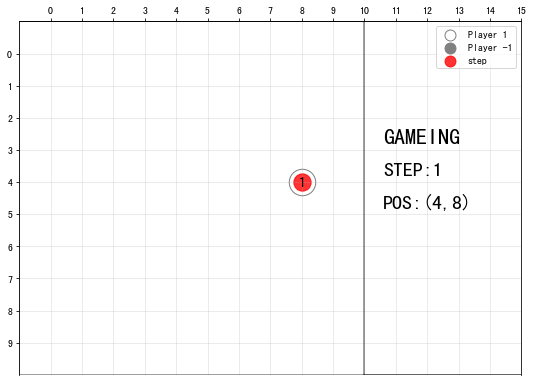

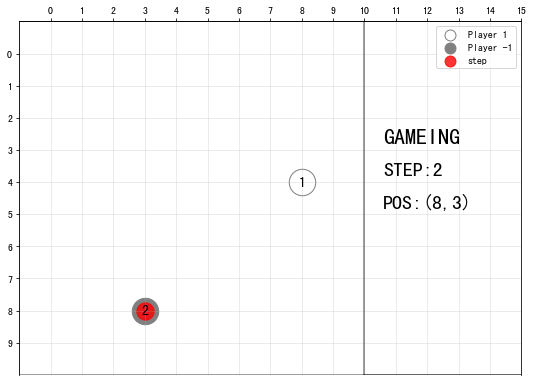

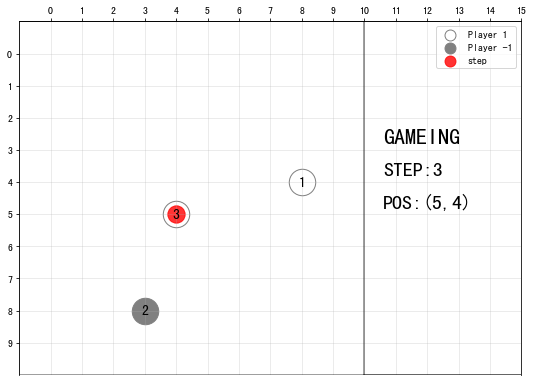

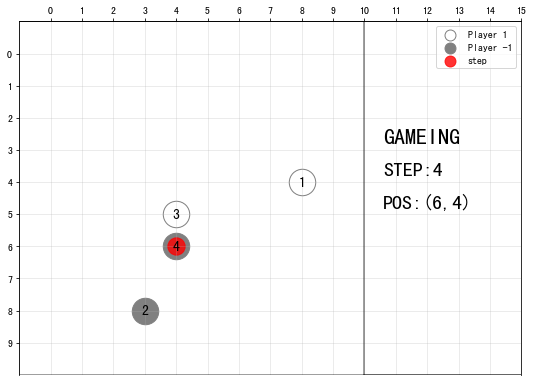

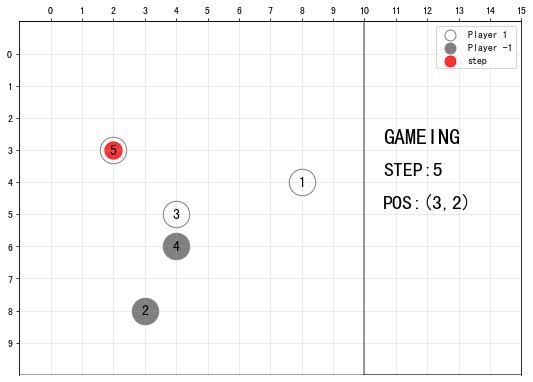

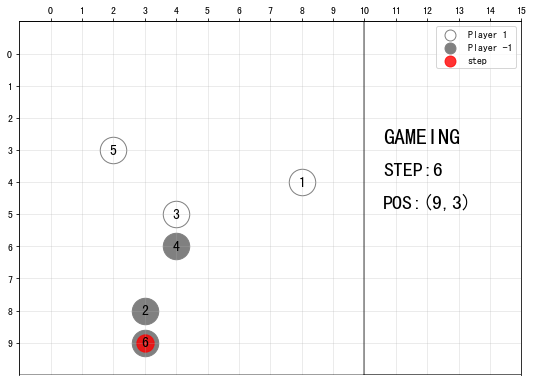

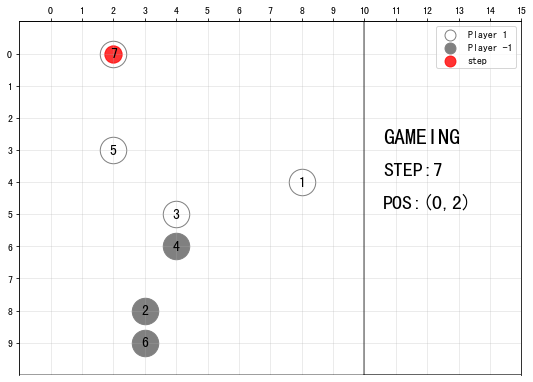

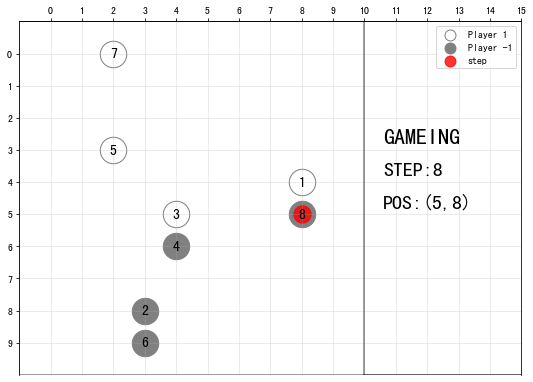

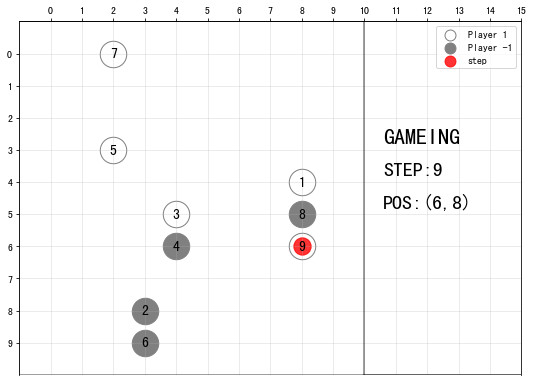

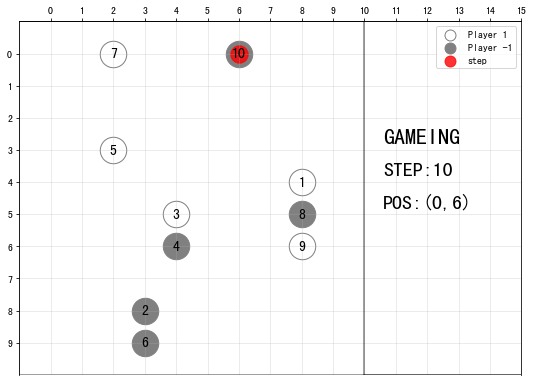

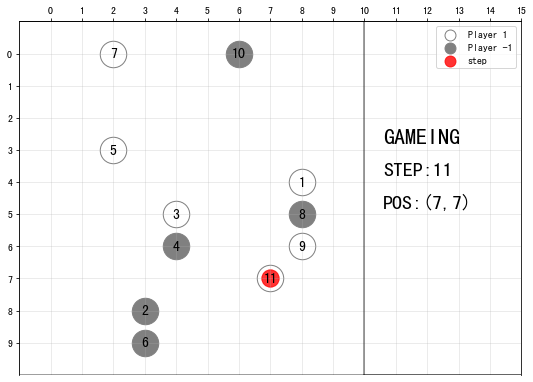

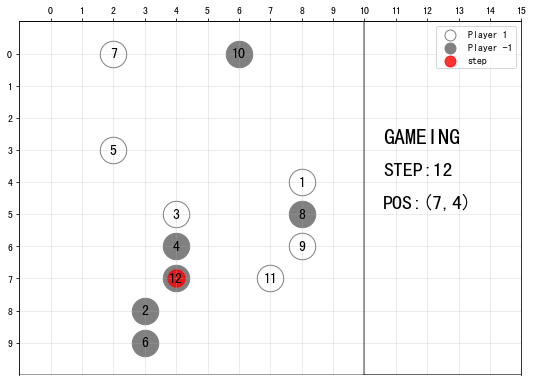

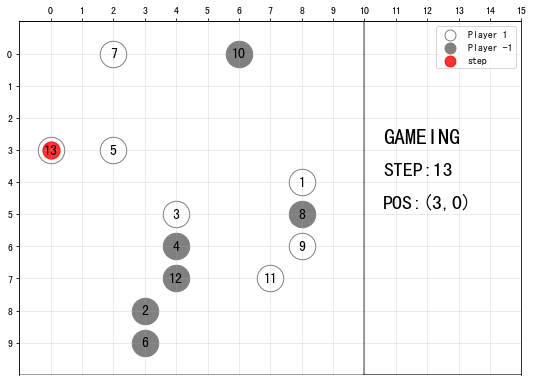

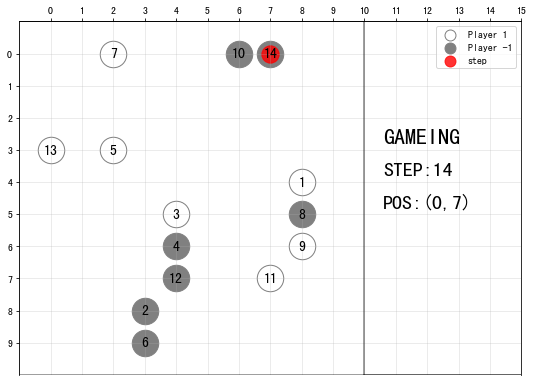

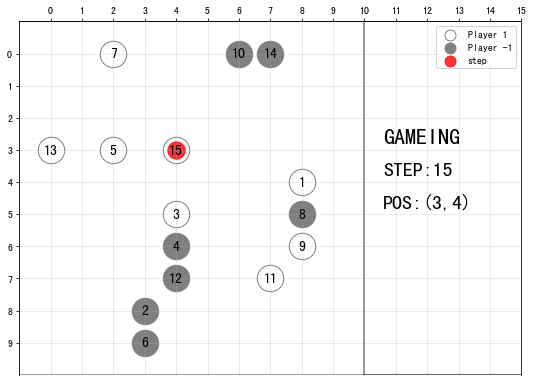

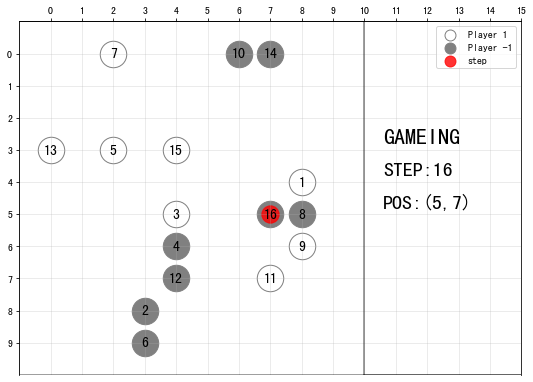

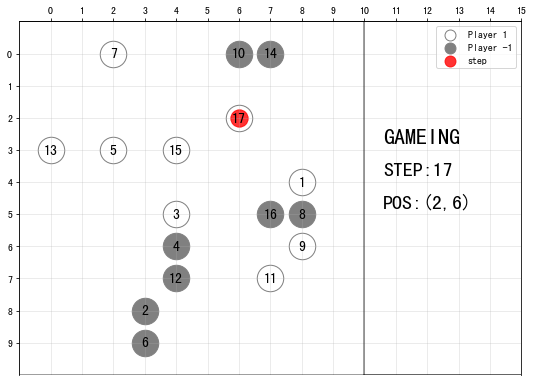

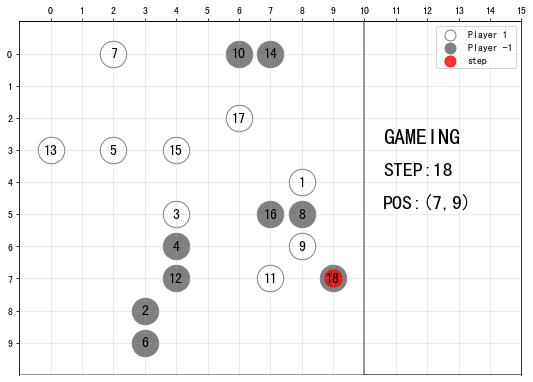

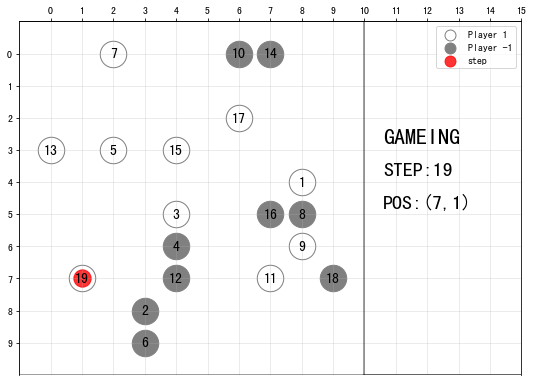

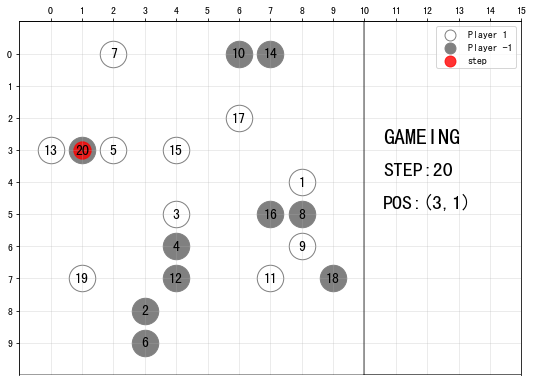

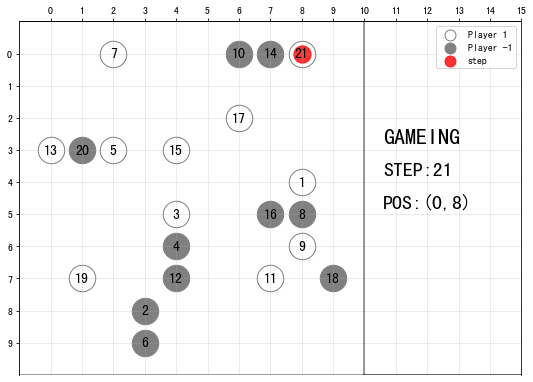

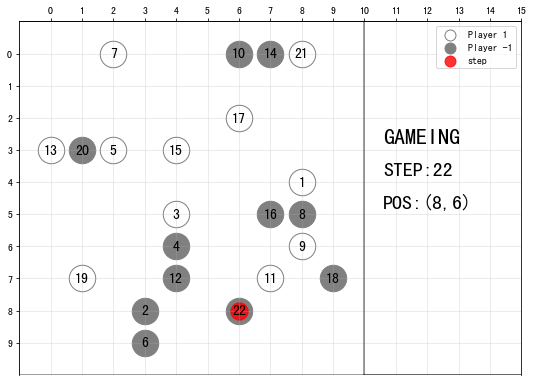

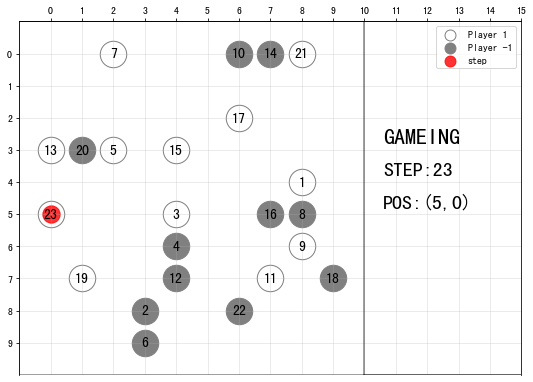

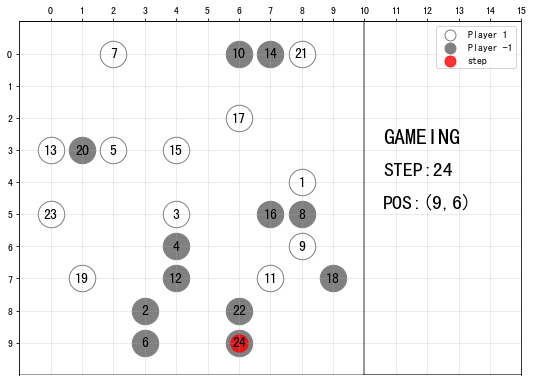

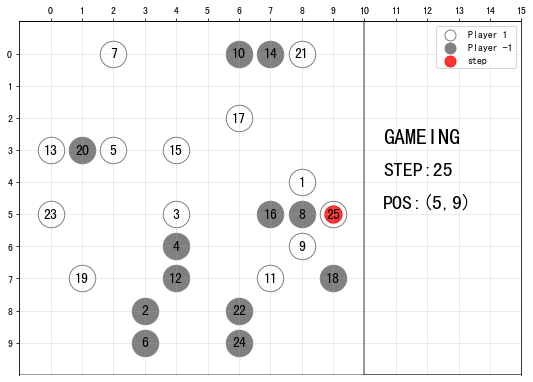

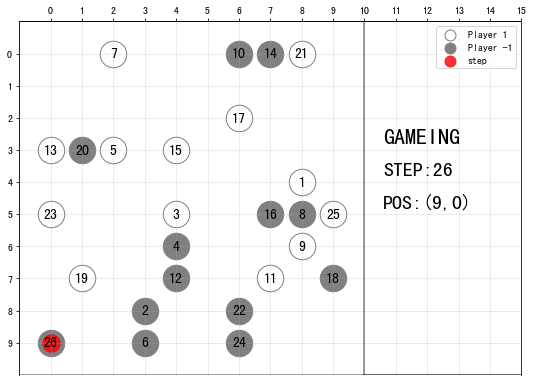

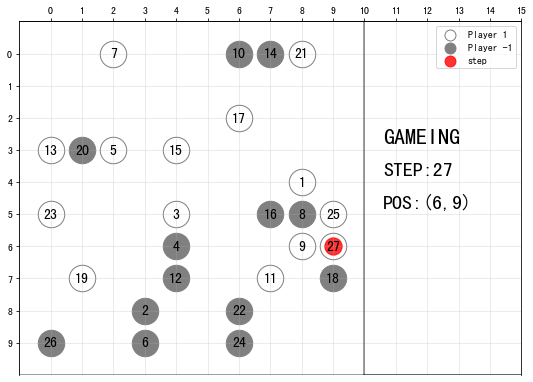

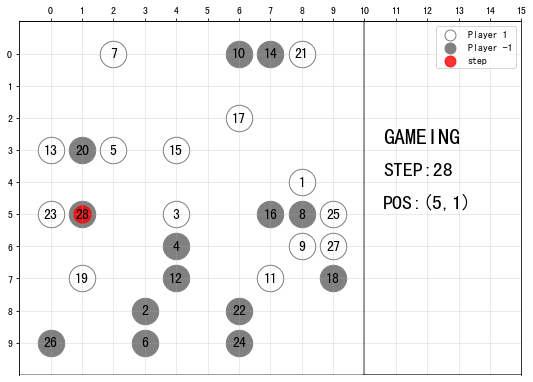

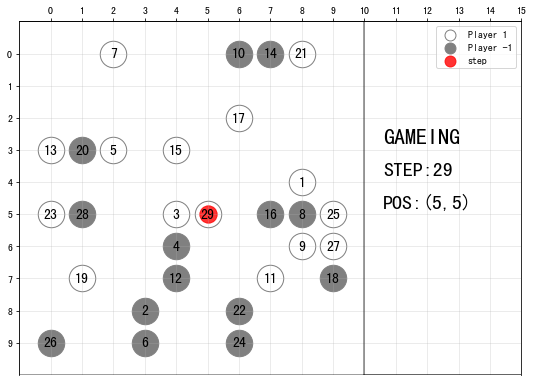

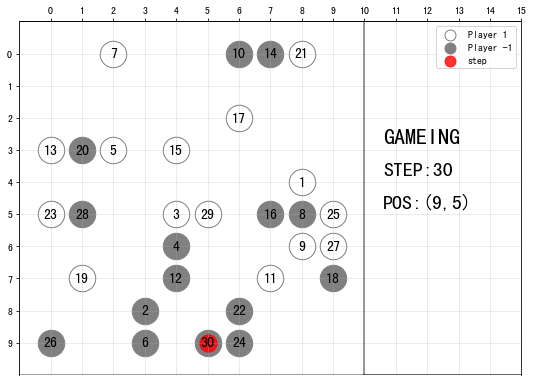

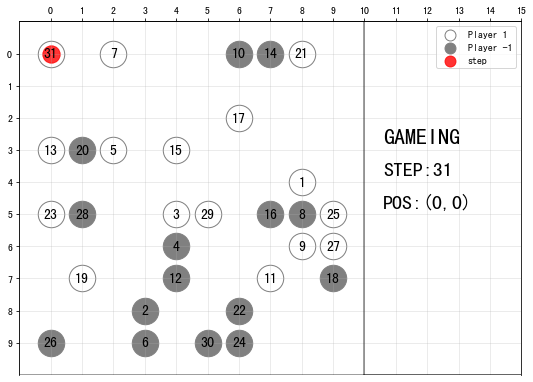

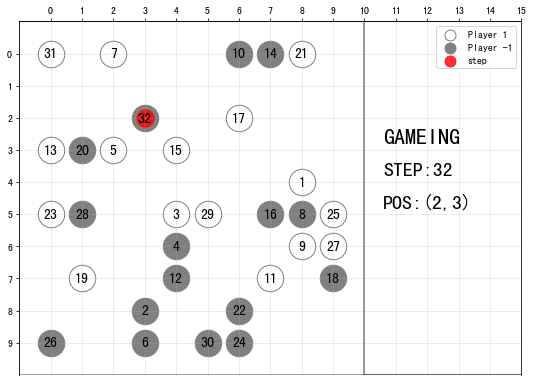

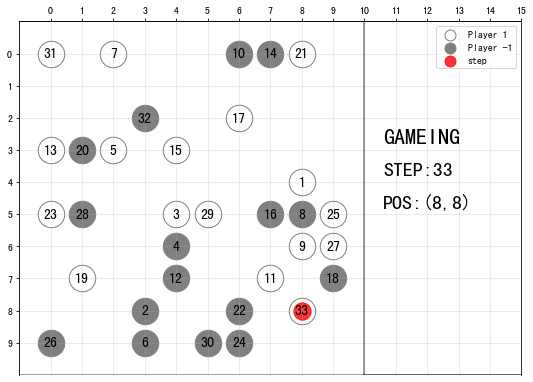

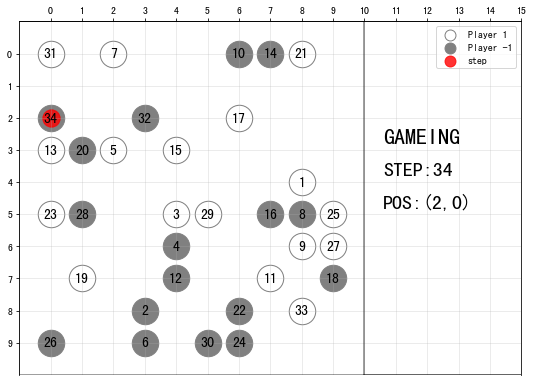

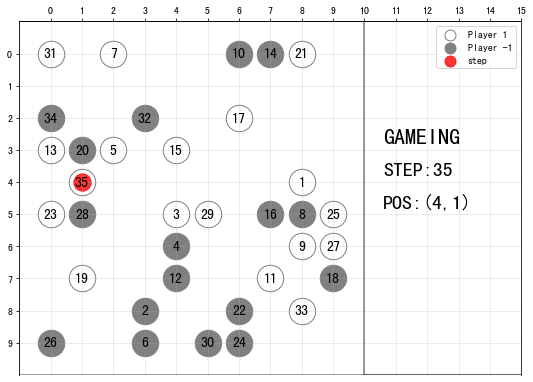

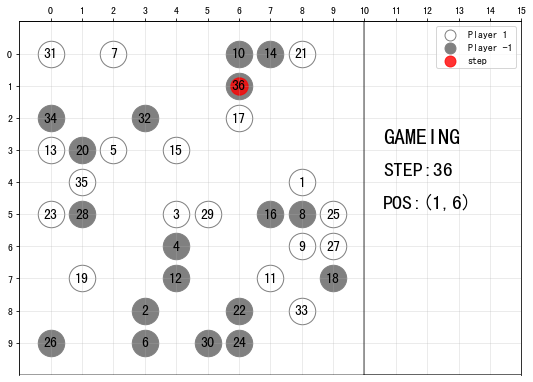

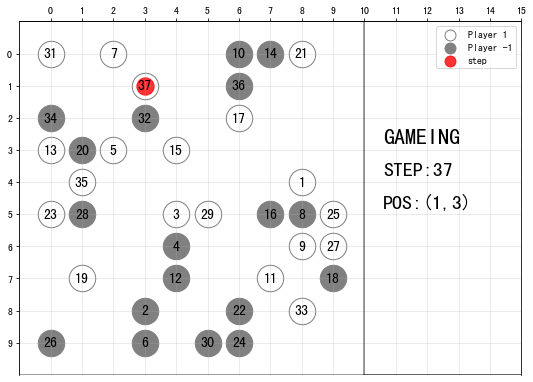

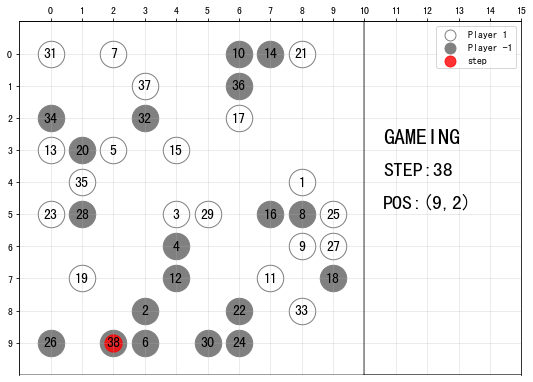

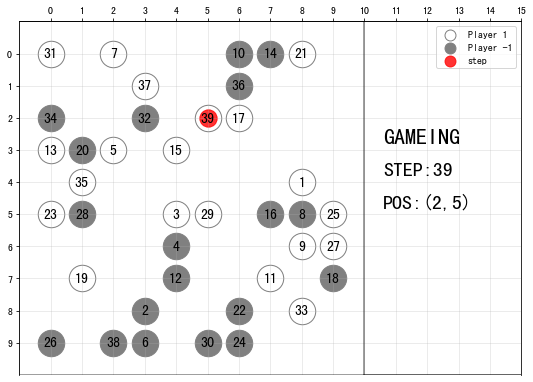

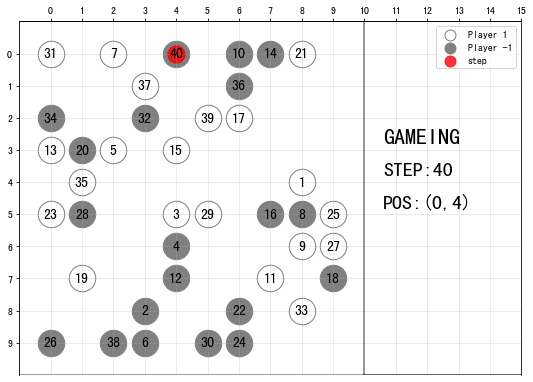

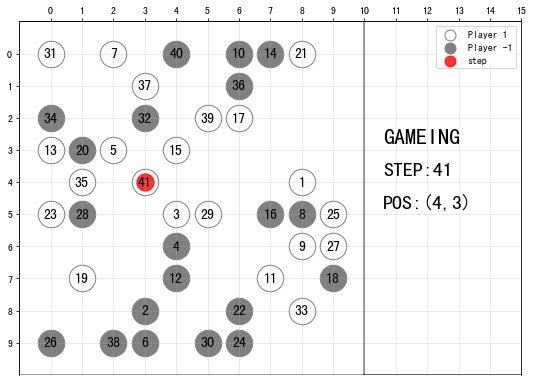

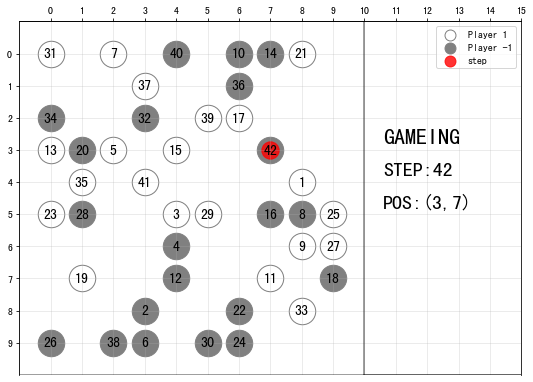

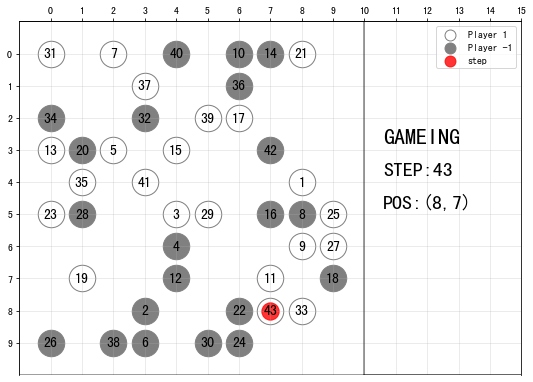

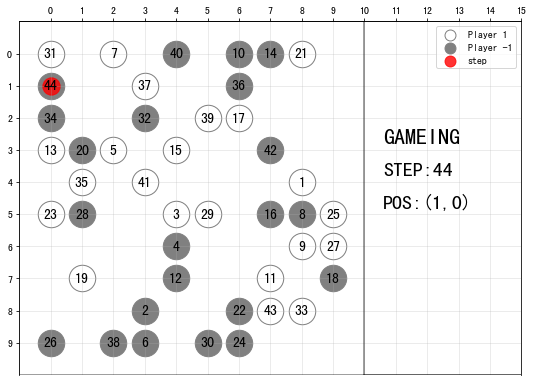

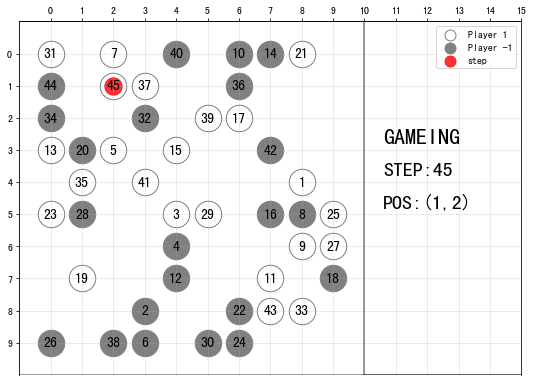

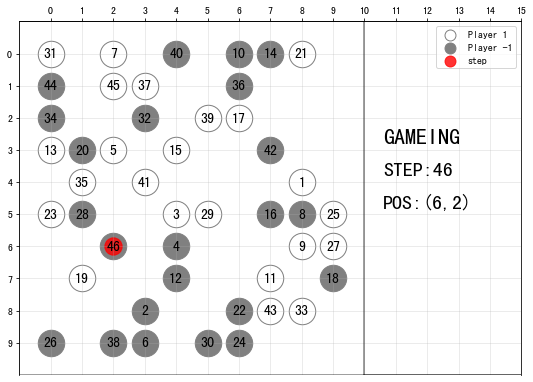

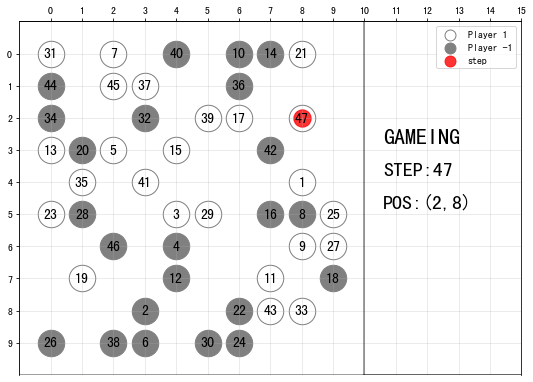

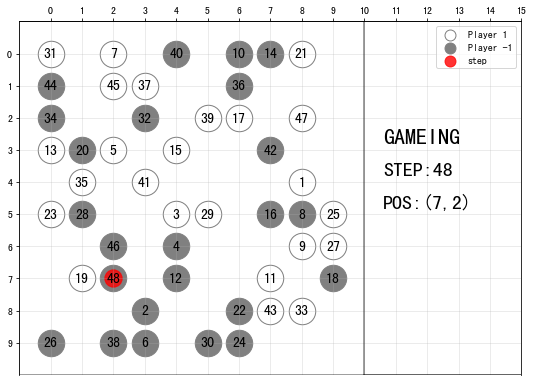

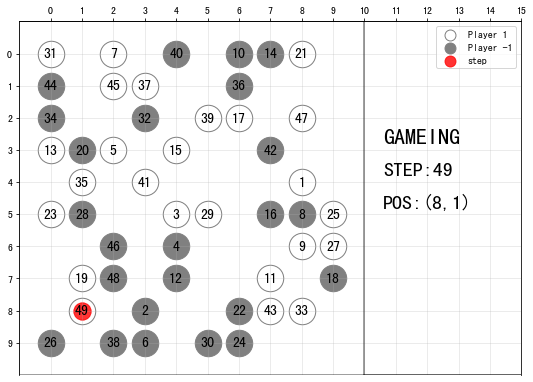

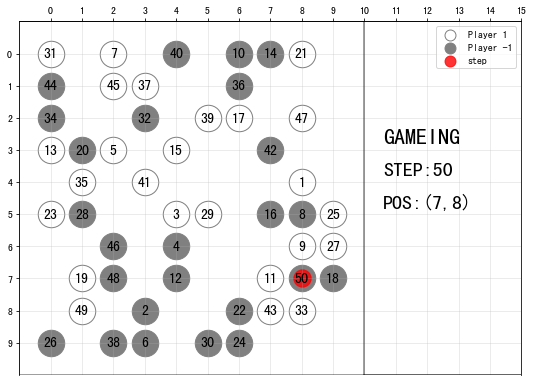

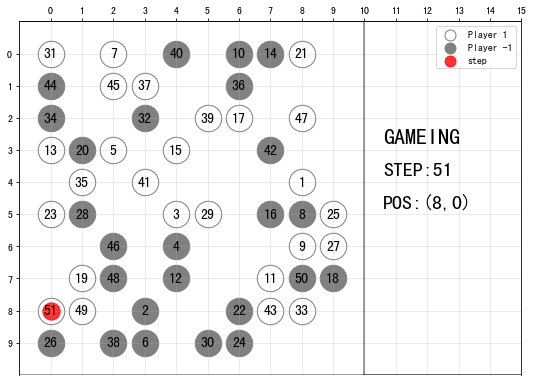

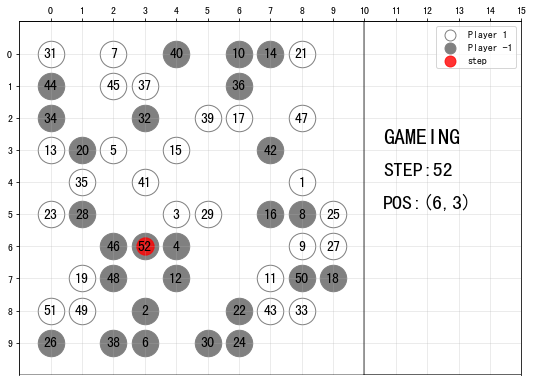

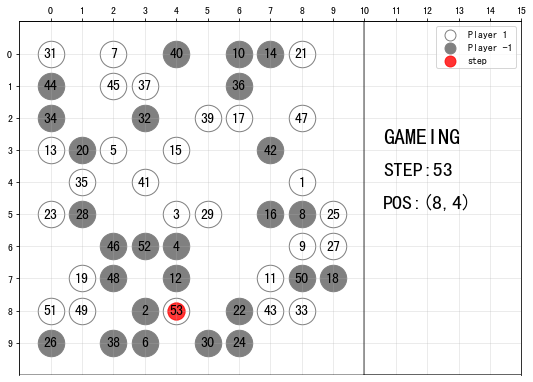

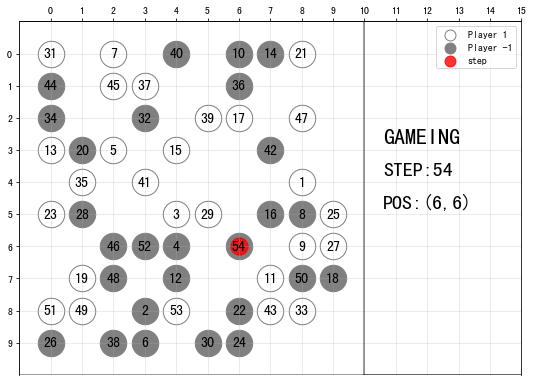

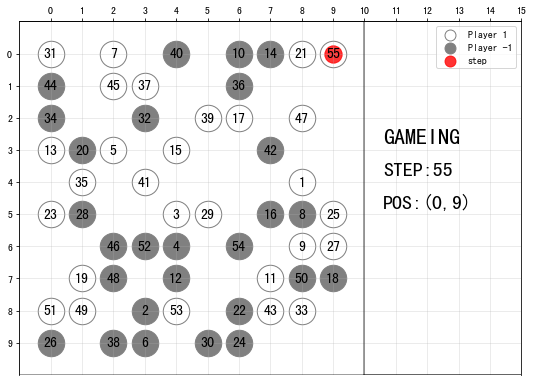

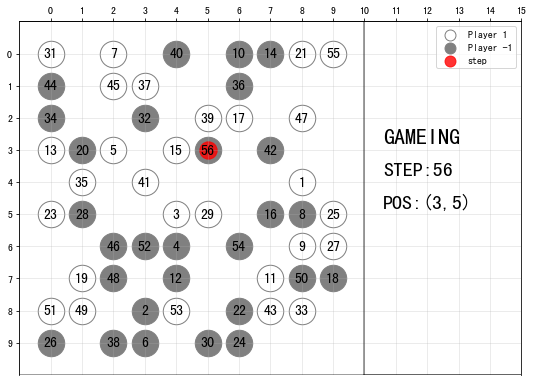

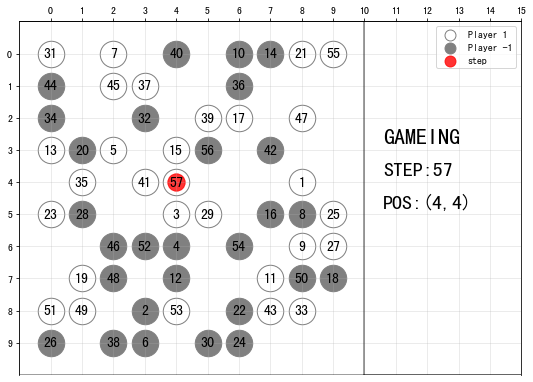

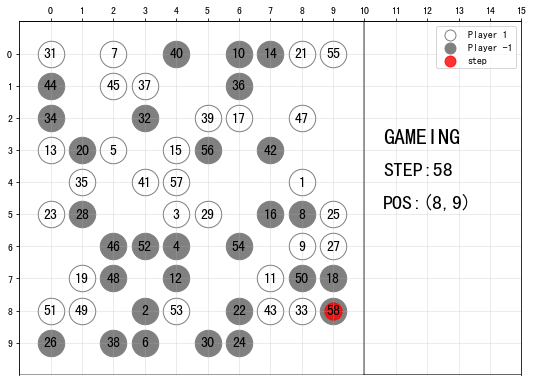

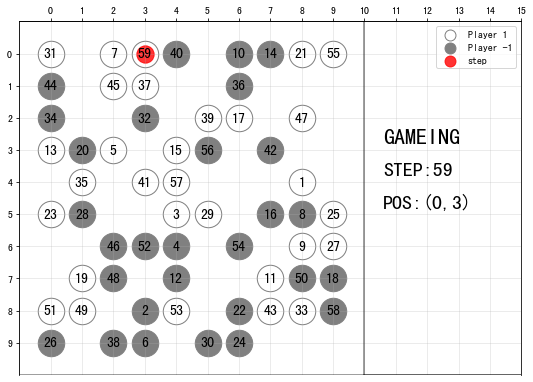

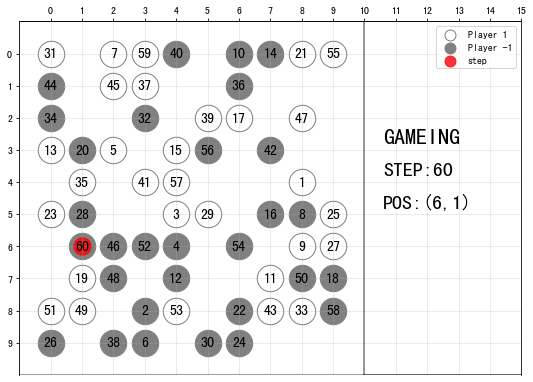

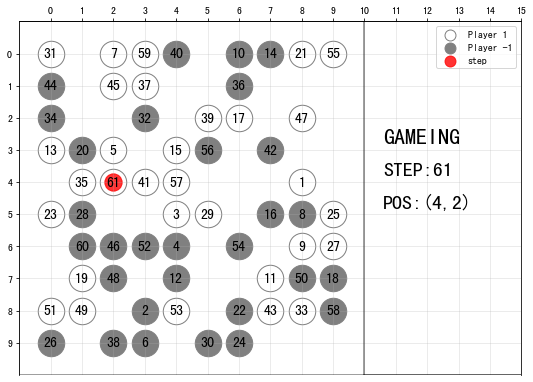

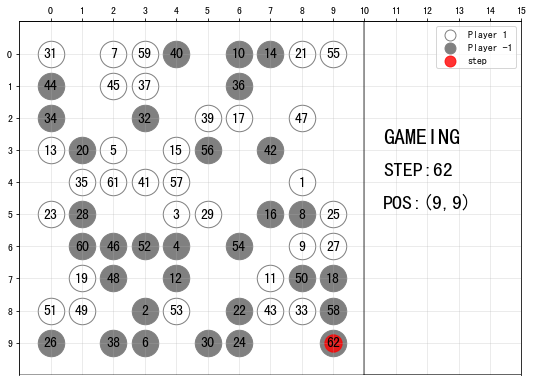

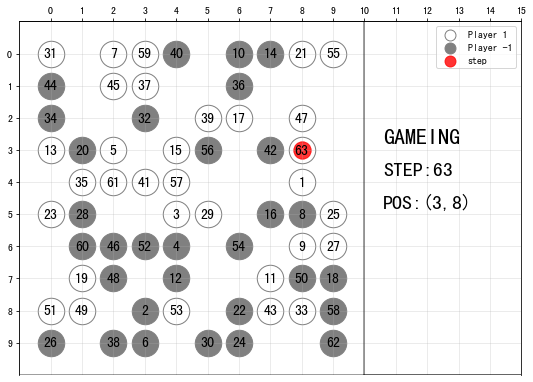

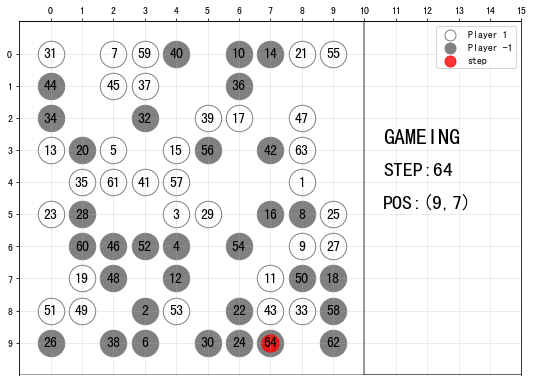

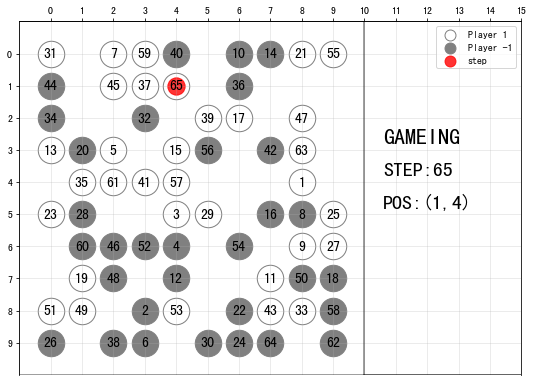

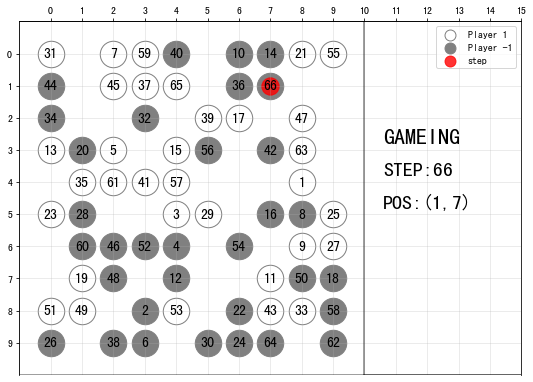

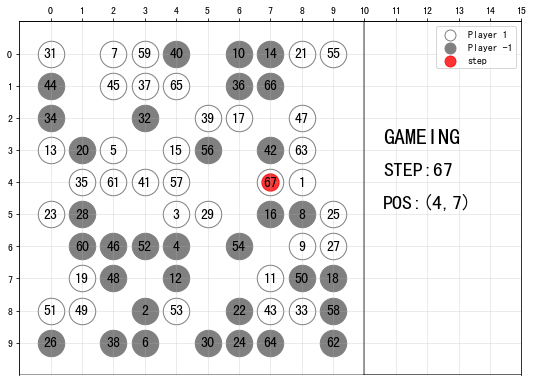

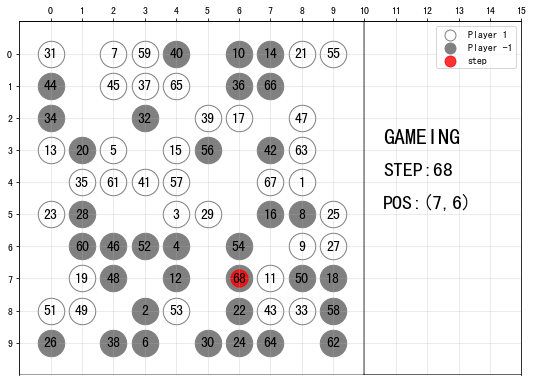

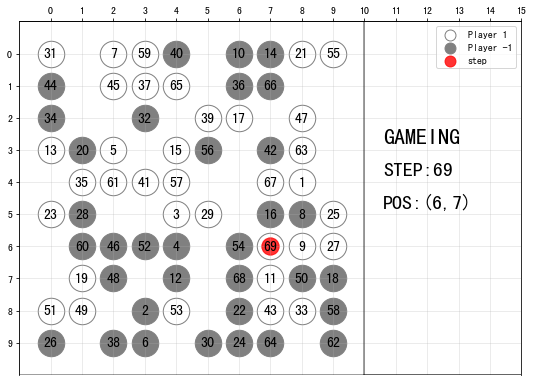

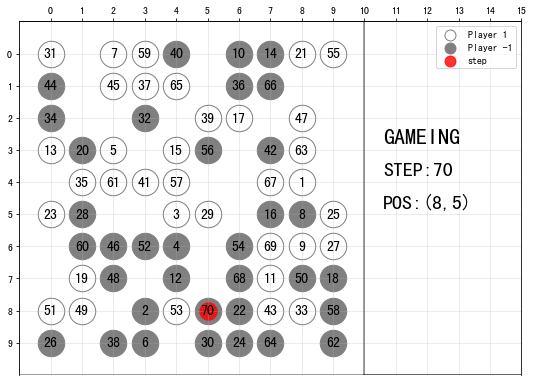

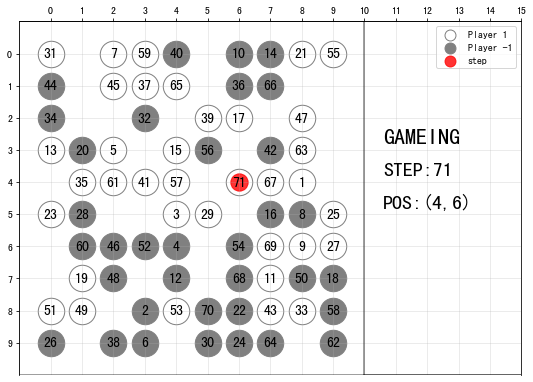

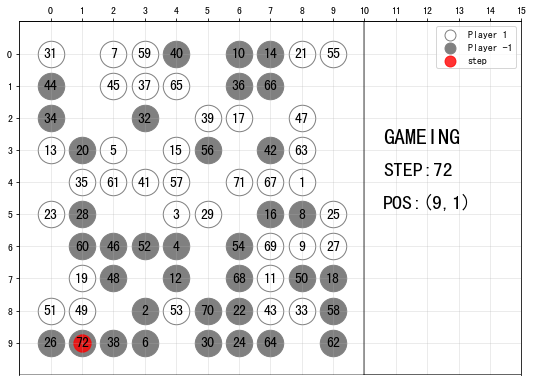

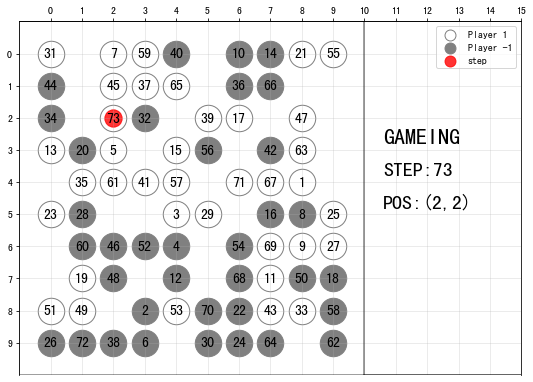

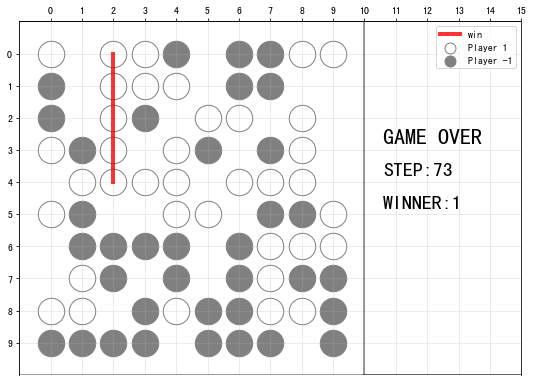

[1.0]

In [10]:
self_play(Player('random'), Player('random'), play_round=1, show=True)

# 定义蒙特卡洛树
Q值更新更改方式错了
概率值做softmax

In [11]:
class TreeNode():
    def __init__(self, board, p):
        self._father = None
        self._board = board # 记录当前节点的棋盘（主要提取state和出手角色）
        self._children = {} # {action: node}
        self._n_visit = 0 # 总共访问次数
        self._n_win = 0  # 节点胜利次数
        self._W = 0 # 合计行动价值
        self._Q = 0  # self._W / self._n_visit
        self._U = 0  # UCB 第二项
        self._P = p # 给定state通过神经网络计算出的概率

In [12]:
class MctsTree():
    def __init__(self, board, net, c, n_playout):
        self._root_node = TreeNode(board=board, p=1)
        self._current_node = self._root_node
        self._c = c # 控制 UCB 第二项的 C 值
        self.net = net  # Resnet神经网络，计算 p 值用，就是用来训练的那个 Restnet 神经网络
        self._action_to_idx =  {y: x for x, y in enumerate(product([x for x in range(10)], repeat=2))}
        self._nodes = [self._root_node]
        self._n_playout = n_playout
        
        
    # mtcs搜索最终执行函数 
    def mcts_process(self):
        for i in range(self._n_playout):
            self.process()
        
        # v 值提取
        value = self._root_node._Q
        
        # p，v 值提取（如果该位置是不能下子的，概率为0）
        proba, node_v = self.get_return_p()
        
        return value, proba, node_v

    
    # 执行一次 MTCS 搜索，返回一个 p 和 v
    def process(self):
        
        # 每完成一次随机模拟后，要返回跟节点重新找节点
        self._current_node = self._root_node
        
        # select 操作，判断现在节点是否存在未走过的情况，如过没有则根据UCT值选取当前节点的子节点
        while True:
            children_action = self._current_node._children
            availables = self._current_node._board.availables()
            
            if len(children_action) < len(availables):
                break
            else: 
                self._current_node = self.select(self._current_node)
        
        
        # 如果当前节点不是终局，才执行 expand、simluate、backup 操作
        result = self._current_node._board.is_end(show_result=False)
        
        if result == 'not end':
            
            # expand 操作
            action = random.choice(list(set(availables) - set(children_action))) # 随机选择一个action，并保证不重复
            new_child_node = self.expand(self._current_node, action)

            # simluate 快速走子操作，并提取value(胜利1，输-1，平局为0)
            value = self.simulate(new_child_node._board)

            # backup 操作更新
            self.backup(new_child_node, value)
        
        else:
            # 如果节点是已经分胜负状态不做模拟，只更新节点访问次数---修改
            self.backup(self._current_node, result)

        
    # 通过 UCB 值选择节点
    def select(self, father_node):
        node_to_ucb_dict = {x: self.UCB(x) for x in father_node._children.values()}  # 节点：ucb值，字典
        return max(node_to_ucb_dict.items(), key=lambda x: x[1])[0]      # 提取值最大的节点
    
    
    # expand 操作，初始化子节点，已经注册父与子节点的关系
    def expand(self, father_node, action):
        # 获取下子后的状态，即当前节点的状态
        node_board = copy.deepcopy(father_node._board) # 取父节点
        node_board.add(action, show=False) # 下一步棋之后就是当前状态
        
        # 通过神经网络获取新增节点的先验概率 p 值
        state = node_board._state
        proba = self.get_node_p(state, action)
        
        # 新增子节点
        child_node = TreeNode(board=node_board, p=proba)
        father_node._children[action] = child_node # 在父节点增加子节点
        child_node._father = father_node # 在子节点增加父亲节点
        
        # 记录所有节点方便检查
        self._nodes.append(child_node)
        return child_node
    
    
    # simulate 模拟操作
    def simulate(self, board):
        
        # 设置一个随机选手随机对奕，棋盘类中对角色已有记录和转换
        copy_board = copy.deepcopy(board) # 复制一份，不然会修改节点的_board属性
        player = Player('random')  # 一名随机的选手
        
        # 循环对奕，判断为终局跳出循环
        while copy_board.is_end(show_result=False) == 'not end':
            copy_board = player.play(copy_board, show=False)

        result = copy_board.is_end(show_result=False) 
        return result  # 先手方（训练方）胜利返回1，后手方胜利放回-1，平局返回0
    
    
    # backup 回传操作
    def backup(self, leaf_node, value):
        
        # 如果有父节点，则递归更新
        if leaf_node._father != None:
            leaf_node._n_visit += 1
            leaf_node._n_win += (1 if value == 1 else 0)
            leaf_node._W += value
            leaf_node._Q = leaf_node._W / leaf_node._n_visit
            return self.backup(leaf_node._father, value)
            
        leaf_node._n_visit += 1
        leaf_node._n_win += (1 if value==1 else 0)
        leaf_node._W += value
        leaf_node._Q = leaf_node._W / leaf_node._n_visit


    # 通过神经网络获取节点的先验概率 p 值
    def get_node_p(self, state, action):
        _, policy = self.net(state)
        torch_idx = self._action_to_idx[action]
        p = policy[0][torch_idx].item()
        return p
    
    
    # 计算 UCB 值
    def UCB(self, node):
        node._Q = node._W / node._n_visit
        node._U = self._c * node._P * (node._father._n_visit) ** 0.5 / (1 + node._n_visit)
        return node._Q + node._U
    
    # 计算 Q 的 softmax
    def softmax(self, x):
        return np.exp(x) / np.exp(x).sum()
    
    # 计算需要输出的p值和对应的action
    def get_return_p(self):
        action_idx = [self._action_to_idx[x] for x in self._root_node._children.keys()]
        sub_p = self.softmax([x._Q for x in self._root_node._children.values()])
        sub_v = [x._Q for x in self._root_node._children.values()]
        
        # 提取每个行为的概率
        proba = np.zeros(shape=self._root_node._board._length*self._root_node._board._width)
        for idx, p in zip(action_idx, sub_p):
            proba[idx] = p
            
        # 提取每个行为的价值
        action_v = np.zeros(shape=self._root_node._board._length*self._root_node._board._width)
        for idx, v in zip(action_idx, sub_v):
            action_v[idx] = v
        return proba, action_v

# 模型训练

In [ ]:
# 定义模型
net = ResNet(board_length=10, board_width=10)
optimizer = optim.Adam(net.parameters(), lr=0.001)

# net = torch.load('./1temp_model.pt')

# 索引到位置映射
action_idx_to_position =  {x: y for x, y in enumerate(product([x for x in range(10)], repeat=2))}

# 定义player
player_mcts = Player(pattern='human') # 指定下子位置采用 human 模式
player_random = Player(pattern='random') # 随机下子机器人
player_trained = Player(pattern='train', model_path='./temp_model_last.pt')  # 训练过的某个模型

# 定义超参数
EPOCH = 1
start_player = 1
mcts_n_playout = 500
mcts_c = 15
self_play_round = 100


# 训练过程 + 自对奕过程
for epoch in range(EPOCH):

    # 每局开始初始化棋盘，交替先手
    if epoch % 2 == 0:
        board = Board(10, 10, start_player=1)
        state = board._state
    else:
        board = Board(10, 10, start_player=-1)
        random_action = (random.randint(0, 9), random.randint(0, 9))
        board.add(random_action, show=False)
        state = board._state
        
    # 初始化循环状态
    next_game = False
    
    # 对奕不结束则一直循环
    while next_game == False:

        # nn 网络得到v和p 
        v_nn, p_nn = net(state)
        
        # mcts树搜获获得v和p
        mcts = MctsTree(board=board, net=net, c=mcts_c, n_playout=mcts_n_playout)
        v_mcts, p_mcts, action_v = mcts.mcts_process()

        # 计算损失
        optimizer.zero_grad()
        value_loss = F.mse_loss(v_nn.view(-1), torch.Tensor(np.array([v_mcts])))
        policy_loss = -torch.mean(torch.sum(torch.Tensor([p_mcts]) * torch.log(p_nn), 1))
        loss = value_loss + policy_loss
        loss_info = round(loss.item(), 4)
        loss.backward()
        optimizer.step()
        
        # 显示当前训练情况
        
        mcts_bar_data = [x._n_visit for x in mcts._root_node._children.values()]
            
        tensor_p_mcts = torch.Tensor([action_v])
        temp_topk = tensor_p_mcts.topk(5 if tensor_p_mcts.size()[1] > 5 else tensor_p_mcts.size()[1])
        mcts_p_v = temp_topk[0].detach().numpy()[0]
        mcts_p_action = [action_idx_to_position[x] for x in temp_topk[1].detach().numpy()[0]]
        mcts_action_pro_dict = {x: y for x, y in zip(mcts_p_action, mcts_p_v) if x in board.availables()}

        nn_p_pro = p_nn.topk(5 if p_nn.size()[1] > 5 else p_nn.size()[1])[0].detach().numpy()[0]
        nn_p_action = [action_idx_to_position[x] for x in p_nn.topk(5 if p_nn.size()[1] > 5 else p_nn.size()[1])[1].detach().numpy()[0]]
        nn_action_pro_dict = {x: y for x, y in zip(nn_p_action, nn_p_pro) if x in board.availables()}
        
        train_info = [epoch+1, loss_info, v_nn.item()]
        
        print('---- 状态模拟结果 '+'-'*100)
        board.show_for_train(mcts_bar_data, mcts_action_pro_dict, v_mcts, nn_action_pro_dict, train_info)
        
        print('')
        
        print('---- 轮流下子情况 '+'-'*100)
        
        # 提取 mcts 树计算后最好的下子
        action = action_idx_to_position[p_mcts.argmax()]
    
        # mcts结果下子, 下子如果结束，跳出循环
        for player, act, in zip([player_mcts, player_trained], [action, 'auto']):
            board = player.play(board, act, show=True)
            
            if board.is_end(show_result=False) != 'not end':
                print('---- 本轮结束，重新开局 '+'-'*94)
                board.is_end(show_result=True)
                next_game = True             
                break

        # 获取现在状态，继续resnet训练
        state = board._state
    
    # 完成一局保存模型
    torch.save(net, './temp_model_last.pt')
    
    # 每50轮后与随机player对局100盘看胜率
    if (epoch+1) % 50 == 0:
        record = self_play(Player('train'), Player('random'), play_round=self_play_round, show=False)
        print('自动对奕胜率:{:.2f}%'.format(record.count(1)/self_play_round*100))